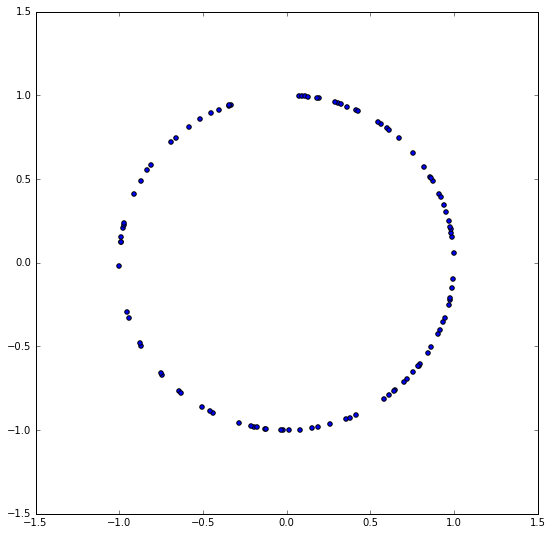

In [220]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from __future__ import print_function, division
import matplotlib

matplotlib.rcParams['figure.figsize'] = (9.0, 9.0)

random = np.random.RandomState(seed=1)

def batch_unit_norm(b, epsilon=1e-8):
    """
    Give all vectors unit norm along the last dimension
    """
    return b / np.linalg.norm(b, axis=-1, keepdims=True) + epsilon

def unit_vectors(n_examples, n_dims):
    """
    Create n_examples of synthetic data on the unit 
    sphere in n_dims
    """
    dense = random.normal(0, 1, (n_examples, n_dims))
    return batch_unit_norm(dense)

toy_dims = 2
toy_examples = 100
toy_dense = unit_vectors(toy_examples, toy_dims)

plt.scatter(toy_dense[:, 0], toy_dense[:, 1])

In [221]:
def hyperplanes(n_planes, n_dims):
    """
    Return n_planes plane vectors, which describe
    hyperplanes in n_dims space that are perpendicular
    to lines running from the origin to each point
    """
    return unit_vectors(n_planes, n_dims)

In [222]:
def random_projection(plane_vectors, data, pack=True):
    """
    Return bit strings for a batch of vectors, with each 
    bit representing which side of each hyperplane the point
    falls on
    """
    output = np.zeros((len(data), len(plane_vectors)), dtype=np.uint8)
    flattened = data.reshape((len(data), -1))
    x = np.dot(plane_vectors, flattened.T).T
    output[np.where(x > 0)] = 1
    if pack:
        output = np.packbits(output, axis=-1).view(np.uint64)
    return output

In [223]:
def orthogonal_vectors(x):
    """
    Given a batch of unit-norm vectors, return
    a batch of vectors that are orthogonal to each
    one
    """
    r = unit_vectors(*x.shape)
    r -= (r * x).sum(axis=-1, keepdims=True) * x
    r = batch_unit_norm(r)
    return r

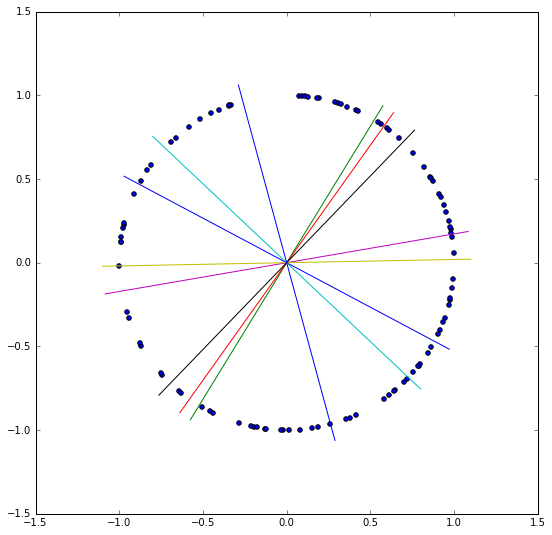

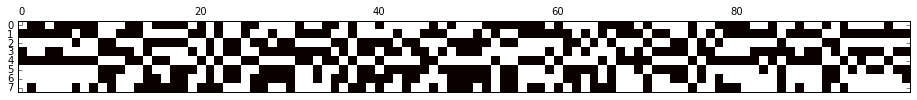

In [227]:
planes = hyperplanes(8, toy_dims)
orth = orthogonal_vectors(planes) * 1.1

plt.scatter(toy_dense[:, 0], toy_dense[:, 1])
for o in orth:
    plt.plot([o[0], -o[0]], [o[1], -o[-1]])

projection = random_projection(planes, toy_dense, pack=False)
plt.matshow(projection.T, cmap='hot')

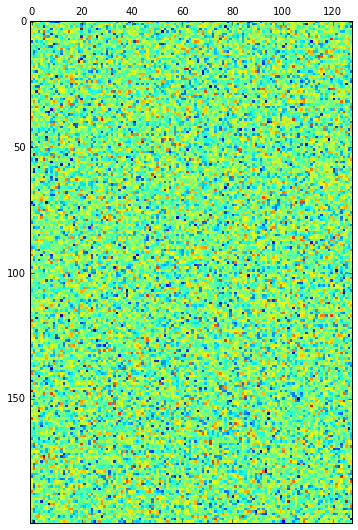

In [228]:
# this represents ~100 hours of audio
n_examples = int(5e5)
n_dims = 128
dense = unit_vectors(n_examples, n_dims)
plt.matshow(dense[:200])

In [229]:
from scipy.spatial.distance import cdist
from zounds.nputil import packed_hamming_distance

query = unit_vectors(1, n_dims).squeeze()

def base_search(data, n_results, dist):
    partitioned_indices = np.argpartition(dist, n_results)[:n_results]
    sorted_indices = np.argsort(dist[partitioned_indices])
    indices = partitioned_indices[sorted_indices]
    return indices

def brute_force_search(query, data, n_results):
    """
    Perform a brute-force cosine distance search
    """
    dist = cdist(query[None, :], data, metric='cosine').squeeze()
    return base_search(data, n_results, dist)

def hamming_distance_search(query, data, n_results):
    """
    Perform a search using only the random projection
    onto bit strings
    """
    dist = packed_hamming_distance(query, data)
    return base_search(data, n_results, dist)

def hybrid_search(query, data, n_results, factor=100):
    """
    Perform a hybrid search, that uses the bit string index
    to narrow the result set, after which a brute-force search
    over the subset is performed
    """
    query, bit_query = query
    data, bit_index = data
    
    indices = hamming_distance_search(bit_query, bit_index, n_results * factor)
    brute_force_indices = brute_force_search(query, data[indices], n_results)
    return indices[brute_force_indices]
    

In [230]:

def experiment(
        data, 
        queries, 
        n_search_results,
        search_func,
        reference_indices=None):
    
    """
    Measure the performance of various search, both
    in terms of speed and accuracy, given reference indices
    that determine the "correct" answer to queries given the
    input data
    """
    
    if reference_indices is None:
        reference_indices = [None] * len(queries)
    
    timings = []
    accuracy = []
    results = []
    
    for query, reference in zip(queries, reference_indices):
        start = time()
        indices = search_func(query, data, n_search_results)
        timings.append(time() - start)
        results.append(indices)
        
        if reference is None:
            continue
        
        intersection = set(indices) & set(reference)
        accuracy.append(len(intersection) / n_search_results)
    
    mean_timings = np.mean(timings)
    mean_accuracy = np.mean(accuracy) if len(accuracy) else 1.0
    results = np.array(results)
    
    return mean_timings, mean_accuracy, results

In [231]:
n_search_results = 50
iterations = 100
queries = unit_vectors(iterations, n_dims)

# measure the performance of the brute-force search
bf_time, bf_accuracy, bf_results = experiment(
    dense, 
    queries, 
    n_search_results, 
    brute_force_search)

# define the different bit or plane counts we'd like
# to experiment with
bit_counts = [64, 128, 256, 512, 1024, 2048]

rp_results = []
hybrid_results = []

for bit_count in bit_counts:
    
    plane_vectors = hyperplanes(bit_count, n_dims)
    bit_index = random_projection(plane_vectors, dense)    
    bit_queries = random_projection(plane_vectors, queries)

    # measure the speed and accuracy of the pure random projection
    # search using bitwise hamming distance
    rp_time, rp_accuracy, _ = experiment(
        bit_index, 
        bit_queries, 
        n_search_results, 
        hamming_distance_search, 
        reference_indices=bf_results)
    rp_results.append((rp_time, rp_accuracy))
    
    # measure the speed and accuracy of the hybrid approach, 
    # which narrows the results on which to use the brute-force
    # approach using the random projection index
    hybrid_queries = [(q, bq) for q, bq in zip(queries, bit_queries)]
    hybrid_time, hybrid_accuracy, _ = experiment(
        (dense, bit_index),
        hybrid_queries,
        n_search_results,
        hybrid_search,
        reference_indices=bf_results)
    hybrid_results.append((hybrid_time, hybrid_accuracy))


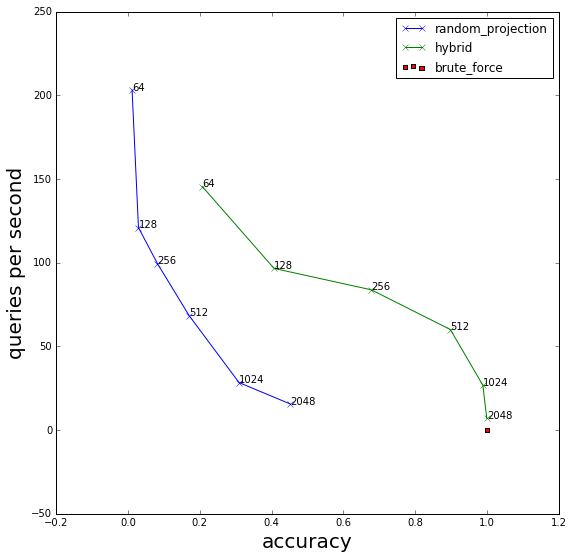

In [232]:
rp_results = np.array(rp_results)
hybrid_results = np.array(hybrid_results)

rp_results[:, 0] = 1.0 / rp_results[:, 0]
hybrid_results[:, 0] = 1.0 / hybrid_results[:, 0]

plt.plot(
    rp_results[:, 1], 
    rp_results[:, 0], 
    marker='x', 
    label='random_projection')
for bit_count, result in zip(bit_counts, rp_results):
    plt.annotate(bit_count, xy=result[::-1], textcoords='data')

plt.plot(
    hybrid_results[:, 1], 
    hybrid_results[:, 0], 
    marker='x', 
    label='hybrid')
for bit_count, result in zip(bit_counts, hybrid_results):
    plt.annotate(bit_count, xy=result[::-1], textcoords='data')

plt.scatter(
    bf_accuracy, 
    bf_time, 
    c='red', 
    marker='s',
    label='brute_force')

plt.xlabel('accuracy', fontsize=20)
plt.ylabel('queries per second', fontsize=20)
plt.legend()